# Lesson 05 Assignment - Hypothesis Simulation 

## Author - Rodolfo Lerma

## Instructions
Use the <a href="https://archive.ics.uci.edu/ml/datasets/Automobile">automotive data set</a> to perform the following:

1. Identify a likely distribution for price and several other features.
2. Compute basic summary statistics by both classical, bootstrap, and Bayesian methods
3. Compute confidence intervals for these summary statistics by classical, bootstrap, and Bayesian methods
4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
            Classical tests
            Tukey’s Honest Significant Differences (HSD)
            Bootstrap methods
            Bayesian model


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
#Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as ss
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import kstest
from scipy import stats
import statsmodels.stats.weightstats as ws    
from statistics import mean
import statsmodels.stats.power as ssp
import itertools
import scipy

In [2]:
#fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"
fileName = "Automobile_price.csv"

In [3]:
auto = pd.read_csv(fileName)

In [4]:
#added_columns = ["normalized-losses","symboling"]
used_columns = ["fuel-type","aspiration","drive-wheels","body-style","price"]
for i in used_columns:
    auto.loc[auto[i] == '?', i] = np.nan
auto[used_columns].isnull().sum()

fuel-type       0
aspiration      0
drive-wheels    0
body-style      0
price           4
dtype: int64

In [5]:
auto.dropna(axis = 0, inplace = True)

#Column price from str to numeric (int64)
auto['price'] = pd.to_numeric(auto['price'])

#Creating a variable called `price_log`
auto['price_log'] = np.log(auto['price'])

# Analysis

## Functions for anaysis

In [6]:
def qq_plot(vec1, vec2):
    plt.figure(figsize=(12, 12)).gca() # define axis
    ax1 = plt.subplot(221) ## setup the left subplot
    ss.probplot(vec1, plot = ax1) ## Plot the left subplot
    ax1 = plt.subplot(222) ## Set up the right subplot
    ss.probplot(vec2, plot = ax1) ## Plot the right subplot
    
def plot_cums(dist1, dist2):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)
    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p, color = 'blue')
    plt.scatter(data_sorted, p, color = 'red')
    # sort the seond data sample:
    data_sorted = np.sort(dist2)
    # And the second plot
    plt.plot(data_sorted, p, color = 'orange')
    plt.scatter(data_sorted, p, color = 'green')

def ks_test(dat, dist = 'norm'):
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))

%matplotlib inline
def hist_plot(vec, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    
def plot_pop(a, b, cols=['pop_A', 'pop_B'], nbins = 20):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

def t_test(a, b, alpha, alternative='two-sided'):
    diff = a.mean() - b.mean()
    res = ss.ttest_ind(a, b, equal_var=False)  
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()
    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)

def hist_mean_ci(vec, t_test, bins):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)
    
#Kernel Density Estimation Plots (to take a look at the Distribution for each of the variables)
def kde_plot(a,b,c,d,e):
    fig = plt.figure(figsize=(10,8)) # Define plot area
    ax = fig.gca() # Define axis 
    sns.set_style("whitegrid")
    sns.kdeplot(a, ax = ax, label = c)
    sns.kdeplot(b, ax = ax, label = d)
    ax.set_title('KDE plot of auto price ' + e, fontsize = 20) # Give the plot a main title
    ax.set_xlabel('Price', fontsize = 15) # Set text for the x axis
    ax.set_ylabel('Density', fontsize = 15)# Set text for y axis
    ax.legend(loc='upper right', fontsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.grid(True)

#Box plot function
def box_plot(a,b,c,d,e):
    a = a.tolist()
    b = b.tolist()
    fig = plt.figure(figsize=(10, 6)) # Define plot area
    boxes_sep = 0.4
    ax = sns.boxplot(data=[a, b], palette="Set2", width=boxes_sep)
    ax1 = sns.violinplot(data=[a, b], color=".22", width=boxes_sep)
    plt.setp(ax1.collections, alpha=0.15)
    ax.set_title('Price by ' + e,  fontsize = 20) # Give the plot a main title
    ax.set_ylabel('Price',  fontsize = 15)# Set text for y axis
    plt.xticks([0,1], (c, d))
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)

## 1) Likely distribution for price and other features

In [7]:
#Normalizing each of the price variables so it is possible to see both with same X axis and compare shapes
norm1_s = scale(auto['price'])
norm2_s = scale(auto['price_log'])

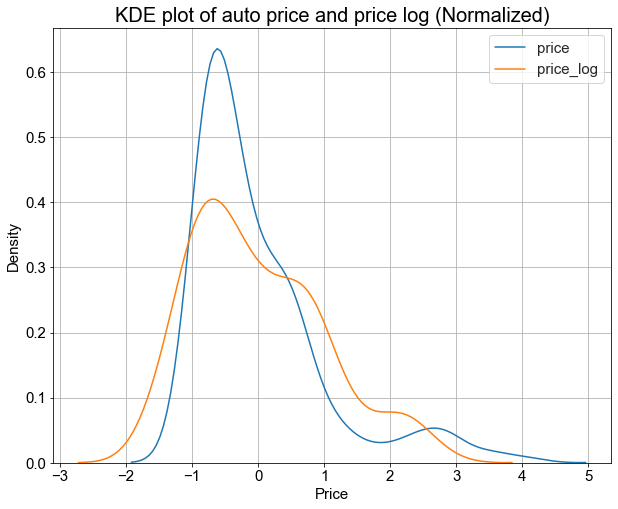

In [8]:
kde_plot(norm1_s,norm2_s,"price","price_log","and price log (Normalized)")

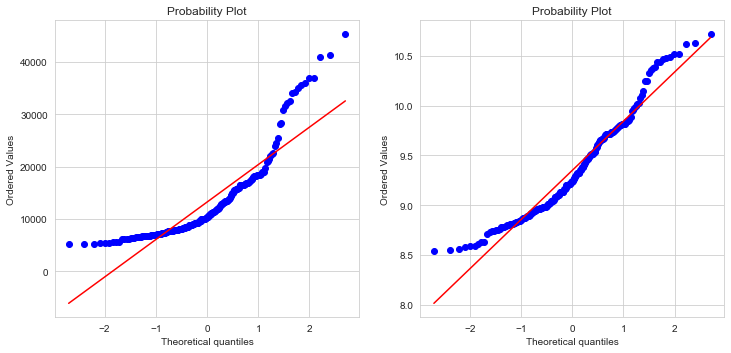

In [9]:
qq_plot(auto['price'], auto['price_log'])  

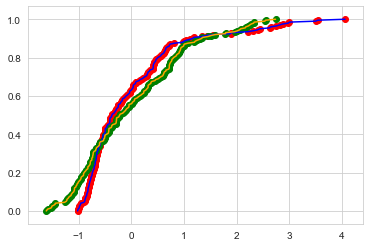

In [10]:
plot_cums(norm1_s, norm2_s) 

In [11]:
ks_test(norm1_s)

KS-statistic = 0.1542761480184771
P-value = 0.00012108611006800808


In [12]:
ks_test(norm2_s)

KS-statistic = 0.09781904713791056
P-value = 0.03984598613097214


### Note: Do this analysis for the variables that we are going to explore in here (to see what kind of distribution we have). Use the notes learned for the facesheet plots

## 2) Basic Summary Statistics by Boostrap & Bayesian 

### Boostrap

In [13]:
print(used_columns)

['fuel-type', 'aspiration', 'drive-wheels', 'body-style', 'price']


In [14]:
auto['fuel-type'].unique()

array(['gas', 'diesel'], dtype=object)

In [15]:
gas = auto[auto['fuel-type'] == 'gas']
diesel = auto[auto['fuel-type'] == 'diesel']
len(gas),len(diesel)

(181, 20)

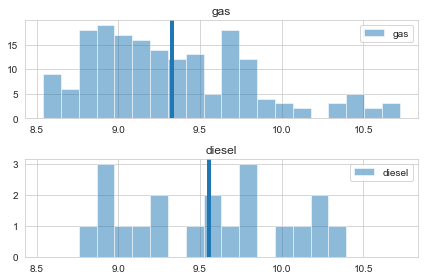

In [16]:
def plot_dists(a, b, nbins, a_label='pop_A', b_label='pop_B'):
    # Create a single sequence of bins to be shared across both
    # distribution plots for visualization consistency.
    combined = pd.concat([a, b])
    breaks = np.linspace(
        combined.min(), 
        combined.max(), 
        num=nbins+1)
    plt.subplot(2, 1, 1)
    plt.hist(a,  bins=breaks, label=a_label, alpha=0.5)
    plt.axvline(a.mean(), linewidth=4)
    plt.legend() 
    plt.title(a_label) 
    plt.subplot(2, 1, 2)
    plt.hist(b,  bins=breaks, label=b_label, alpha=0.5)
    plt.axvline(b.mean(), linewidth=4)
    plt.legend() 
    plt.title(b_label) 
    plt.tight_layout()
    
plot_dists(gas['price_log'], diesel['price_log'], 20, a_label='gas', b_label='diesel')

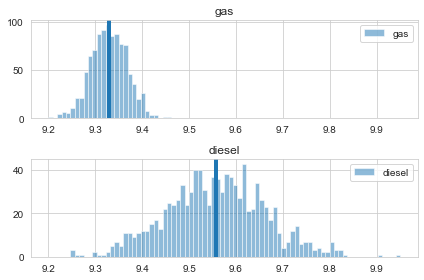

In [17]:
n_replicas = 1000

gas_bootstrap_means = pd.Series([
    gas.sample(frac=1, replace=True).price_log.mean()
    for i in range(n_replicas)])

diesel_bootstrap_means = pd.Series([
        diesel.sample(frac=1, replace=True).price_log.mean()
        for i in range(n_replicas)])

plot_dists(gas_bootstrap_means, diesel_bootstrap_means, 
           nbins=80, a_label='gas', b_label='diesel')

In [18]:
diffs = []
for i in range(n_replicas):
    sample = auto.sample(frac=1.0, replace=True)
    gas_sample_mean = sample[sample['fuel-type'] == 'gas'].price_log.mean()
    diesel_sample_mean = sample[sample['fuel-type'] == 'diesel'].price_log.mean()
    diffs.append(gas_sample_mean - diesel_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs)

NameError: name 'plot_hist' is not defined

In [ ]:
gas_bootstrap_means.describe()

In [ ]:
import statsmodels.api as sm

## Is the bootstrapped distribution Normal?
fig = sm.qqplot(diffs, line='s')
plt.title('Quantiles of standard Normal vs. bookstrapped mean')

### Bayes approach

In [ ]:
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

In [ ]:
N = 1000
p = np.linspace(min(auto.price_log),max(auto.price_log), num=N)

pp_gas = scipy.stats.norm.pdf(p, loc=gas.price_log.mean(), scale= np.std(gas.price_log))
pp_gas = pp_gas / pp_gas.sum() # normalize

def comp_like(p, x): 
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()

like_gas = comp_like(p, auto.price_log)
post_gas = posterior(pp, like_gas)

plt.plot(p, pp_gas, label='prior')
plt.plot(p, like_gas, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_gas, label='posterior')
plt.legend()

In [ ]:
print('Maximum of the prior density = %.3f' % max(pp))
print('Maximum likelihood = %.3f' % float(float(np.argmax(like_gas))/100.0 + 0.01))
print('MAP = %.3f' % float(float(np.argmax(post_gas))/100.0 + 0.01))

In [ ]:
pp_diesel = scipy.stats.norm.pdf(p, loc=diesel.price_log.mean(), scale= np.std(diesel.price_log))
pp_diesel = pp_diesel / pp_diesel.sum() # normalize

like_diesel = comp_like(p, diesel.price_log)
post_diesel = posterior(pp_diesel, like_diesel)

plt.plot(p, pp_diesel, label='prior')
plt.plot(p, like_diesel, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post_diesel, label='posterior')
plt.legend()

In [ ]:
num_samples = 100000
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles. Assumes a pretty symmetrial distribution
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    plt.plot(p, post, color='blue')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x=ci[0], color='red')
    plt.axvline(x=ci[1], color='red')
    print('The %.3f credible interval is %.3f to %.3f' 
          % (interval, lower_q, upper_q))

In [ ]:
plot_ci(p, post_gas, num_samples, lower_q=.025, upper_q=.975)
#plot_ci(p, post_diesel, num_samples, lower_q=.025, upper_q=.975)

In [ ]:
plot_ci(p, post_diesel, num_samples, lower_q=.025, upper_q=.975)

In [ ]:
num_samples = 25
types = auto[auto.gender == 'male'].sample(n=num_samples)

pyplot.title('Histograms of heights of people')
male.childHeight.hist(label='sons', bins=10, alpha=.7)
male.mother.hist(label='mothers', bins=10, alpha=.7)
pyplot.xlabel('Height')
pyplot.legend()

mean_height = numpy.concatenate([male.mother, male.father, male.childHeight,]).mean()
print('Mean of heights: %.1f' % mean_height)

## 3) Confidence intervals of Summary Stats by Boostrap & Bayesian

In [ ]:
#Confidence intervals

## 4) Hypothesis Test (compare t-test, Tukey HSD, ANOVA Vs results from Bootstraping and Bayesian Model)